In [26]:
import random
import warnings

from graphinference import inference_methods
import matplotlib.pyplot as plt
import numpy as np
import pysd
import pandas as pd
import scipy as sp

random.seed(111)
np.random.seed(111)

plt.rcParams['text.usetex'] = True
plt.rcParams["font.family"] = "sans-serif"
plt.rcParams["figure.dpi"] = 300

# A Collection of Non-Linear Stock and Flow Models

### Modeling the Biological Mechanisms That Determine the Dynamics of the Stress Response of the Human Body

Gizem Aktaş and Yaman Barlas 2018

I was able to simulate this model and perturb it with stochastic input, but since it was never published, it isn't well documented.

#### Stock and Flow  Graphic

![](https://metasd.com/wp-content/uploads/2018/09/stress_diag-1024x467.png)

Poster abstract [here.](https://proceedings.systemdynamics.org/2018/proceed/papers/P2360.pdf)

Download available [here](https://metasd.com/2018/09/biological-dynamics-stress-response/).

In [2]:
# Read in the model
stress_model = pysd.read_vensim("../../Data/StressResponseModel/StressResponseModel_converted 8.mdl")
# Run the simulation
X = stress_model.run(params={"External Stress": 1}, final_time=10)
X.describe()

,INITIAL TIME,FINAL TIME,TIME STEP,SAVEPER,Avg Cytokine Input,Cytokine Input,Cytokine Input Averaging,Cytokine Input Avg Time,Cytokine Pulse Duration,Cytokine Pulse End,...,Serotonin Eff on Responsiveness,Ref Cort Responsiveness to Ser,Ref RelTime Responsiveness to Ser,Ser Response to Ser,Ser Responsiveness to Ser,Ref Ser Responsiveness to Ser,Ser Eff on Ser,"""DR Curve for Serotonin-Serotonin""","""DR Curve for Ser-Cortisol""","""DR Curve for Ser-RelTime"""
count,321.0,321.0,321.00000,321.00000,321.0,321.0,321.0,321.0,321.00000,321.0,...,321.000000,3.210000e+02,321.0,321.000000,321.000000,321.0,321.000000,321.000000,321.000000,321.000000
mean,0.0,10.0,0.03125,0.03125,0.0,0.0,0.0,24.0,0.03125,30.0,...,0.979837,8.000000e-01,5.0,0.738192,1.989427,2.0,1.251235,0.370861,0.662510,0.960889
std,0.0,0.0,0.00000,0.00000,0.0,0.0,0.0,0.0,0.00000,0.0,...,0.008433,2.223913e-16,0.0,0.109610,0.007990,0.0,0.102335,0.053649,0.108834,0.021233
min,0.0,10.0,0.03125,0.03125,0.0,0.0,0.0,24.0,0.03125,30.0,...,0.972234,8.000000e-01,5.0,0.627725,1.975208,2.0,1.000000,0.317802,0.375000,0.900000
25%,0.0,10.0,0.03125,0.03125,0.0,0.0,0.0,24.0,0.03125,30.0,...,0.972701,8.000000e-01,5.0,0.638573,1.982282,2.0,1.178428,0.322140,0.646241,0.962240
50%,0.0,10.0,0.03125,0.03125,0.0,0.0,0.0,24.0,0.03125,30.0,...,0.976458,8.000000e-01,5.0,0.683525,1.990226,2.0,1.306701,0.343441,0.700808,0.968089
75%,0.0,10.0,0.03125,0.03125,0.0,0.0,0.0,24.0,0.03125,30.0,...,0.983554,8.000000e-01,5.0,0.818915,1.997011,2.0,1.343709,0.410012,0.742001,0.974737
max,0.0,10.0,0.03125,0.03125,0.0,0.0,0.0,24.0,0.03125,30.0,...,1.000000,8.000000e-01,5.0,1.000000,2.000000,2.0,1.348541,0.500000,0.757483,0.977236


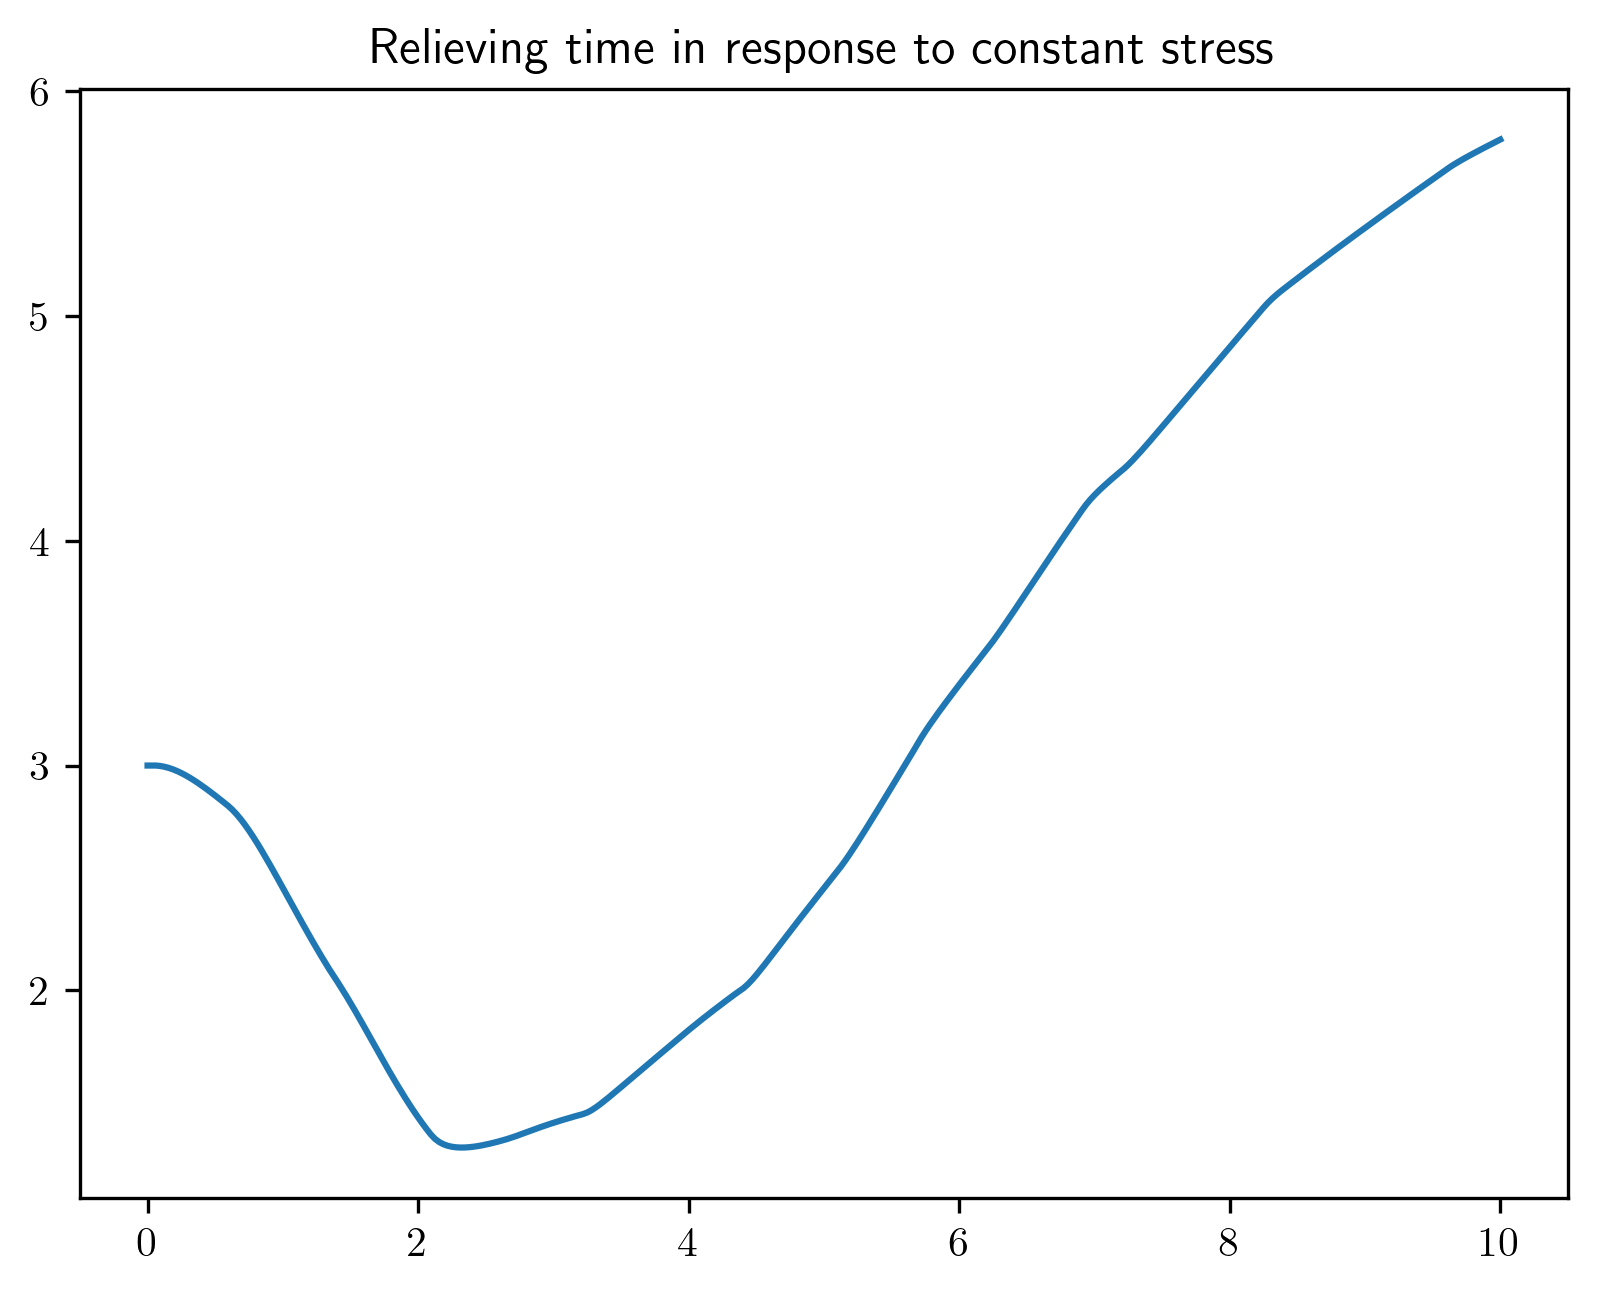

In [3]:
plt.plot(X["Relieving Time"])
plt.title("Relieving time in response to constant stress")
plt.show()

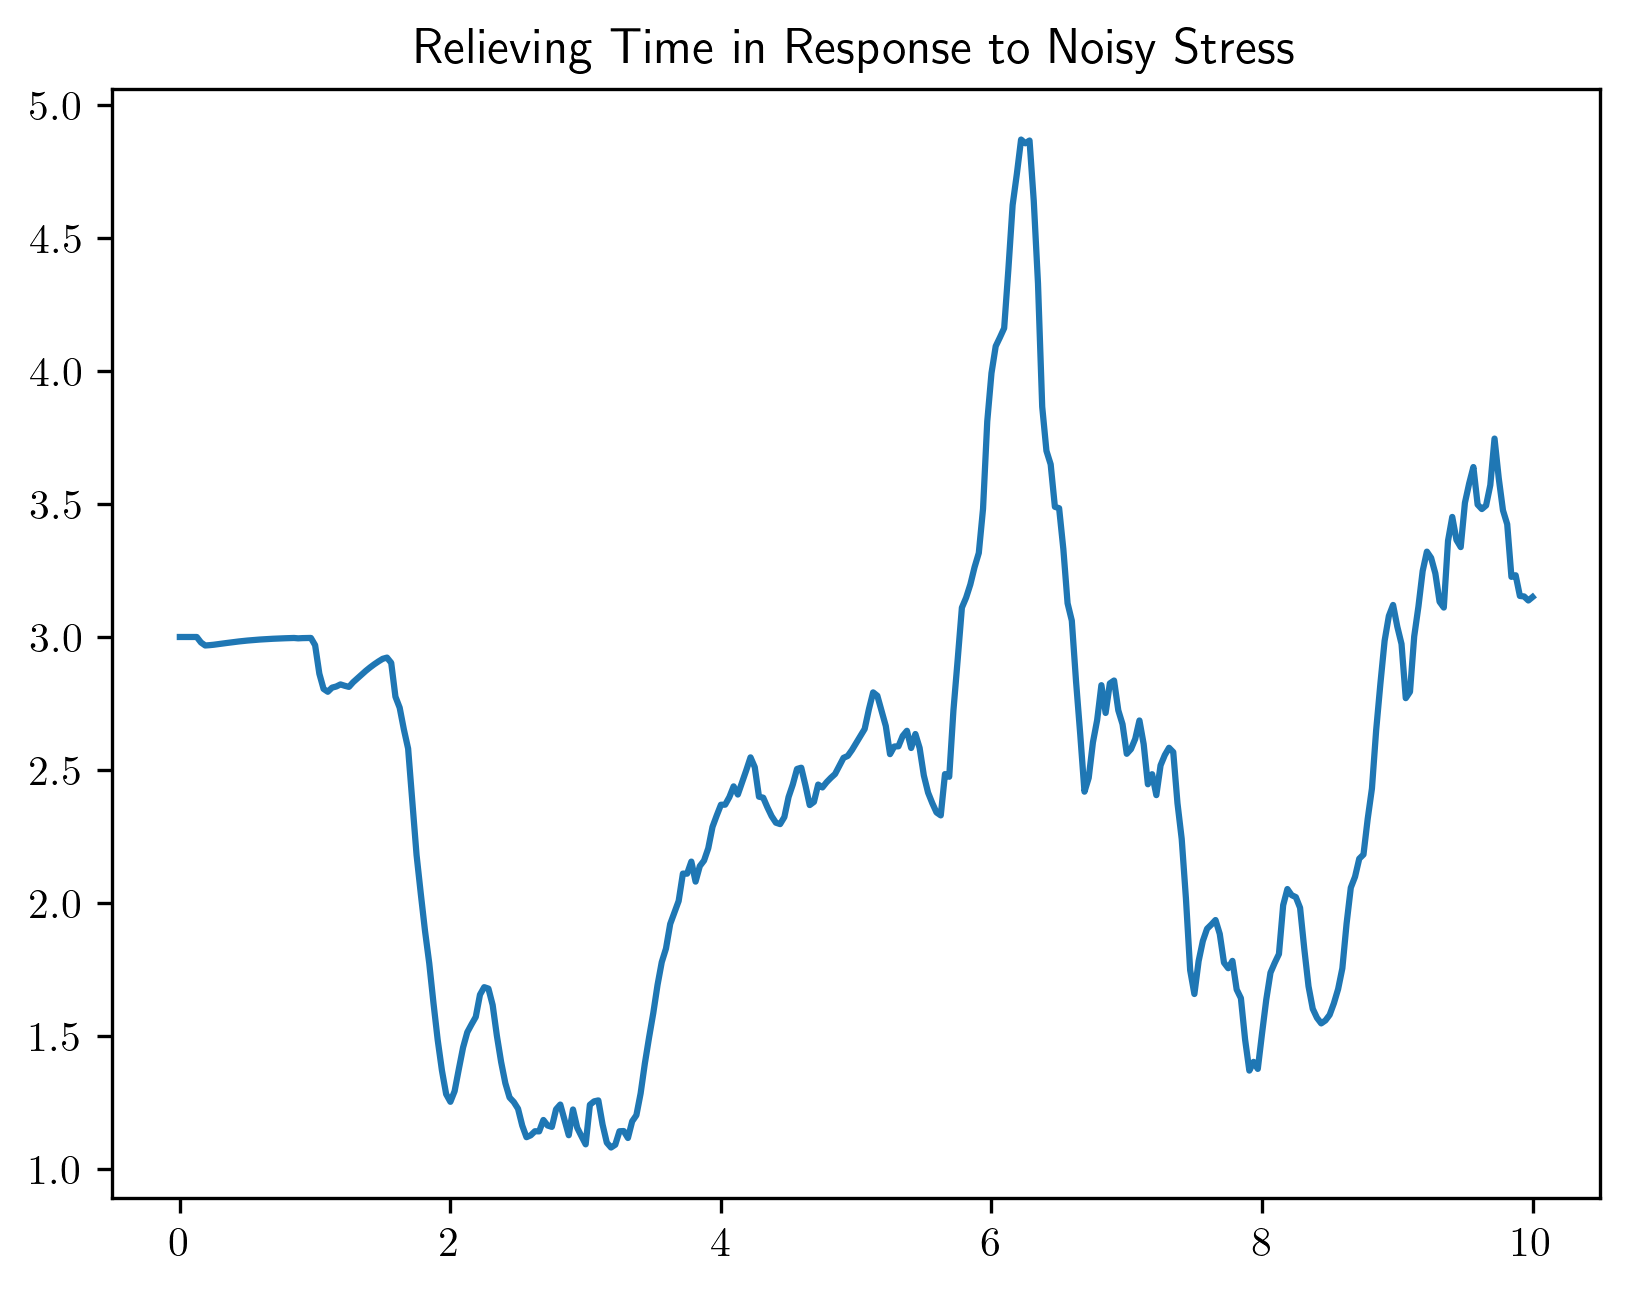

In [4]:
noisy_extern_stress = lambda : 1 + 10 * np.random.randn()

stress_model.components.external_stress = noisy_extern_stress
X = stress_model.run(final_time=10)
plt.plot(X["Relieving Time"])
plt.title("Relieving Time in Response to Noisy Stress")
plt.show()

### Financial Instability Model

Available [here](https://exchange.iseesystems.com/models/player/crelis/financial-instability).

In [5]:
financial_model = pysd.read_xmile("../../Data/FinancialInstabilityModel/Financial-instability.stmx")

/Users/djpassey/Code/graphinference/graphinf_venv/lib/python3.9/site-packages/pysd/builders/python/python_expressions_builder.py:462: UserWarning: 

Trying to translate 'HISTORY' which it is not implemented on PySD. The translated model will crash... 
  warnings.warn(


Because `pysd` does not implement a `HISTORY` operation, it can't simulate time delays. By looking into the .stmx file, and generated python model, I was able to implement the delay component of economic growth rate as follows.

In [6]:

class EconomicGrowthRate:
    """Economic growth rate in the finanial instability model.

    Stores historical production values in order to implement
    a delay. Pysd does not implement Stella's HISTROY function.
    """
    def __init__(self):
        self.time = []
        self.production_history = []
        self.delay = 1.0

    def __call__(self):

        # Check if the simulation was restarted
        current_time = financial_model.components.time()
        initial_time = financial_model.components.initial_time()
        time_step = financial_model.components.time_step()
        if (current_time - initial_time) < time_step:
            # Reset history if the simulation was restarted
            self.time = []
            self.production_history = []

        # Retrieve and store current time and economic production
        self.time.append(current_time)
        curr_production = financial_model.components.production()
        self.production_history.append(curr_production)

        # In the case that there is not enough history return zero
        if current_time < self.delay:
            return 0.0

        # Interpolate past production
        prev_production_func = sp.interpolate.interp1d(
            self.time,
            self.production_history
        )
        # Retrieve past production
        prev_production = prev_production_func(current_time - self.delay)
        # Return (p[t] - p[t-1]) / p[t-1] where p is production.
        return financial_model.components.zidz(curr_production - prev_production, prev_production)


        

In [7]:
# Assign this new growth rate function to the model.
financial_model.components.economic_growth_rate = EconomicGrowthRate()

# Simulate
econ_indicators = ["capital", "economic growth rate", "employment rate", "profits", "wage share"]
X = financial_model.run(
    final_time=800,
    return_columns=econ_indicators,
    initial_condition=(0, {"capital": 200})
)


### Simulation of Financial Instability

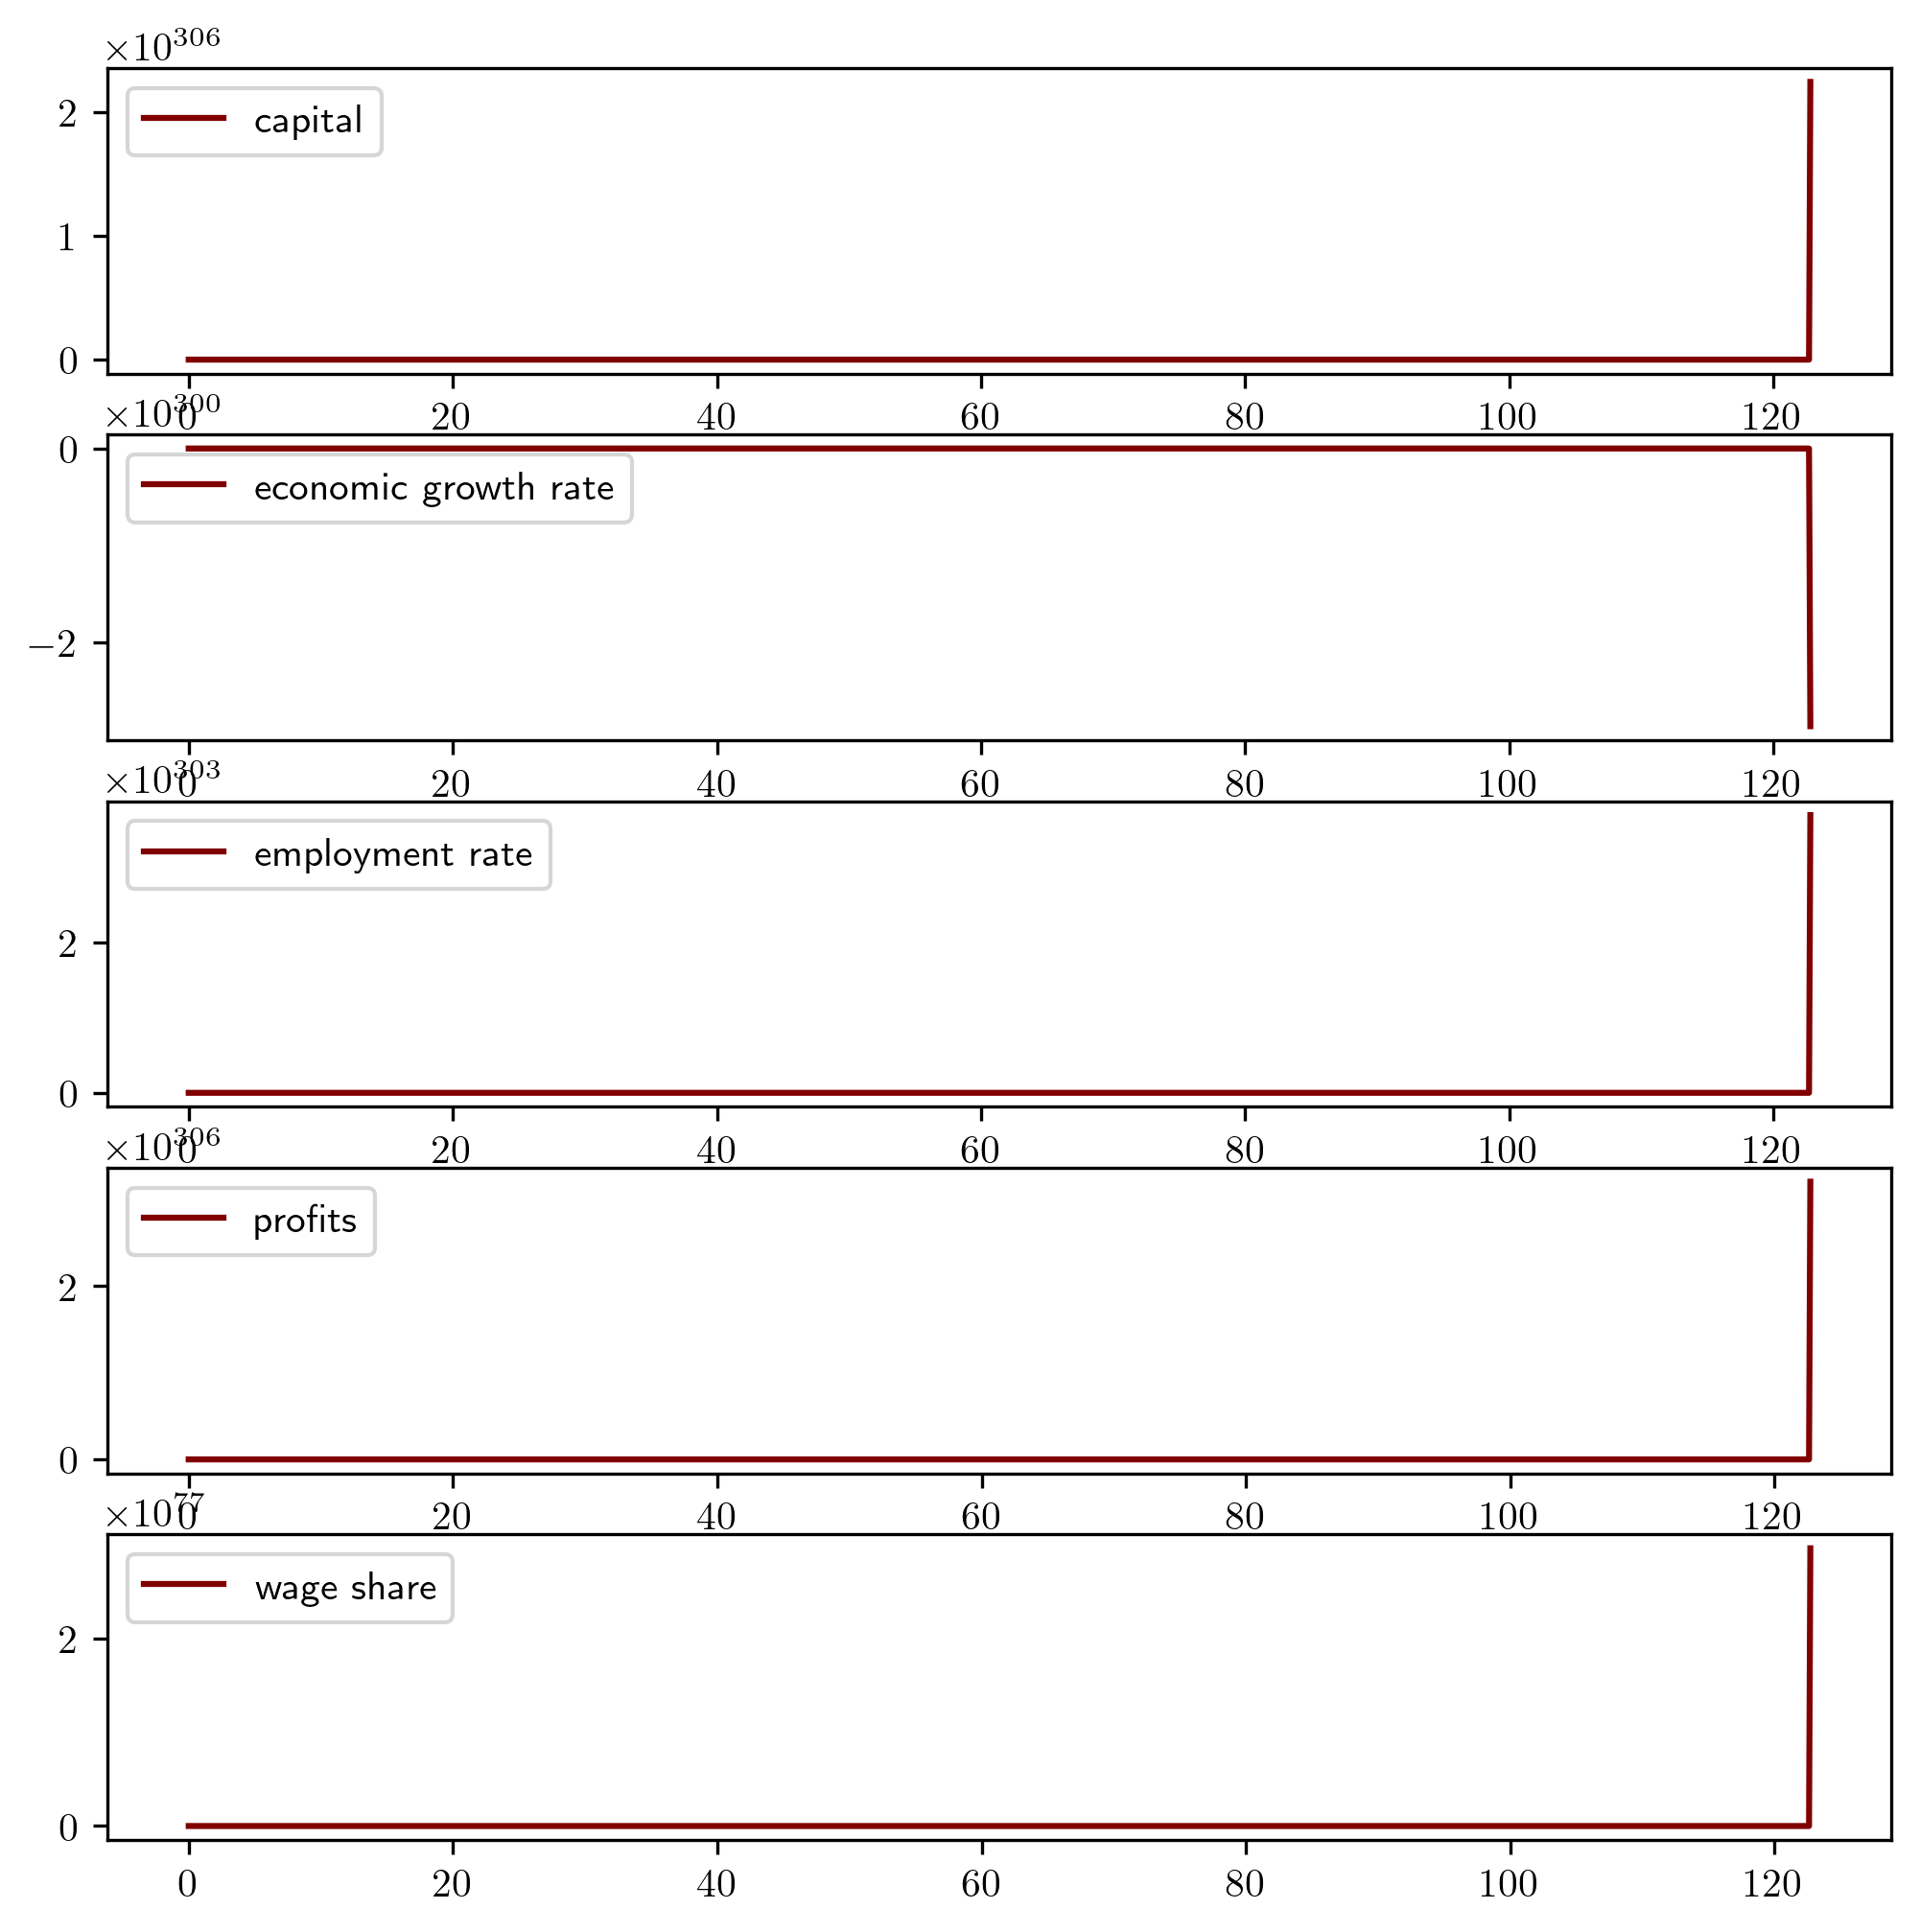

In [8]:

fig, ax = plt.subplots(5, 1, figsize=(8,8))
for i, ei in enumerate(econ_indicators):
    ax[i].plot(X[ei], label=ei, color="maroon")
    ax[i].legend()


plt.show()

#### Helpful Links

[Opiod use model](https://jamanetwork.com/journals/jamanetworkopen/fullarticle/2723405)

[MetaSD Model library](https://metasd.com/model-library/)

### Homer Covid 19 Model
![](https://metasd.com/wp-content/uploads/2020/03/diagram-1200x862.png)
[Link](https://metasd.com/2020/03/model-covid-19-us/)

In [34]:
covid19_model = pysd.read_vensim("../../Data/HomerCOVID19v2/Covid19US v2tf.mdl")

/Users/djpassey/Code/graphinference/graphinf_venv/lib/python3.9/site-packages/pysd/builders/python/python_expressions_builder.py:462: UserWarning: 

Trying to translate 'X IF MISSING' which it is not implemented on PySD. The translated model will crash... 
  warnings.warn(
/Users/djpassey/Code/graphinference/graphinf_venv/lib/python3.9/site-packages/pysd/py_backend/external.py:457: UserWarning: _ext_data_cumul_confirmed_cases_data
Data value missing or non-valid in:
	File name:	'/Users/djpassey/Code/graphinference/Data/HomerCOVID19v2/Covid19US data.xlsx'
	Sheet name:	'Data'
	Reference cell:	'd3'



  warnings.warn(
/Users/djpassey/Code/graphinference/graphinf_venv/lib/python3.9/site-packages/pysd/py_backend/external.py:457: UserWarning: _ext_data_dead_data
Data value missing or non-valid in:
	File name:	'/Users/djpassey/Code/graphinference/Data/HomerCOVID19v2/Covid19US data.xlsx'
	Sheet name:	'Data'
	Reference cell:	'e3'



  warnings.warn(


In [35]:
def dead_frac_conf_cases():
    dead_data = covid19_model.components.dead_data()
    cumul_conf_cases = covid19_model.components.cumul_confirmed_cases_data()
    return dead_data / cumul_conf_cases

setattr(covid19_model.components.dead_frac_of_confirmed_cases_data, "type", "Auxiliary")
covid19_model.components.dead_frac_of_confirmed_cases_data = dead_frac_conf_cases

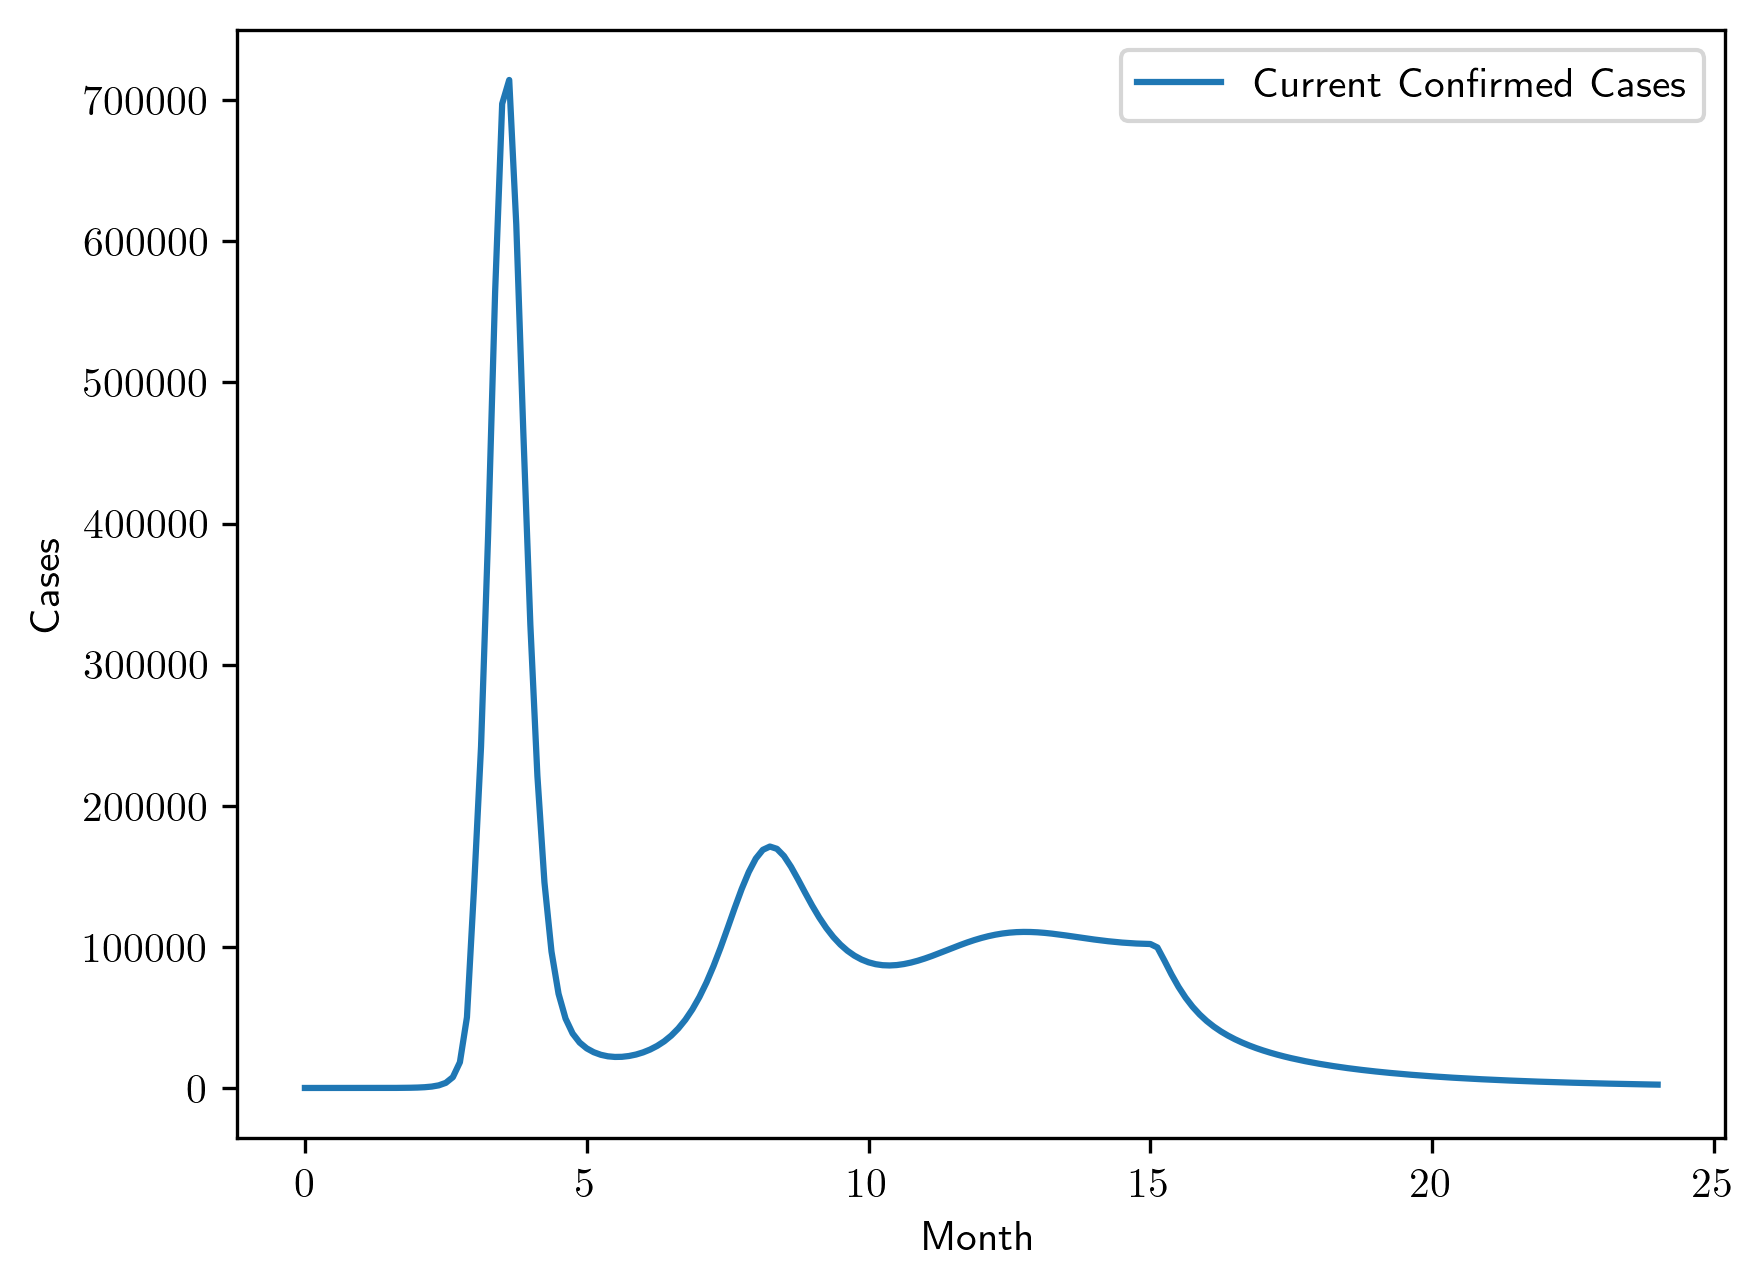

In [36]:
with warnings.catch_warnings():
    warnings.filterwarnings("ignore")
    X = covid19_model.run()

plt.plot(X[["Confirmed current cases"]], label="Current Confirmed Cases")
plt.xlabel("Month")
plt.ylabel("Cases")
plt.legend()

## Thyroid Dynamics

In [38]:
thy_model = pysd.read_vensim("../../Data/ThyroidDynamics/thyroid-2008-d.mdl")

/Users/djpassey/Code/graphinference/graphinf_venv/lib/python3.9/site-packages/pysd/builders/python/python_expressions_builder.py:462: UserWarning: 

Trying to translate 'DELAY MATERIAL' which it is not implemented on PySD. The translated model will crash... 
  warnings.warn(


NameError: name 'time_step' is not defined

## Job Tenure

In [39]:
job_model = pysd.read_vensim("../../Data/JobTenure/job_tenure.mdl")

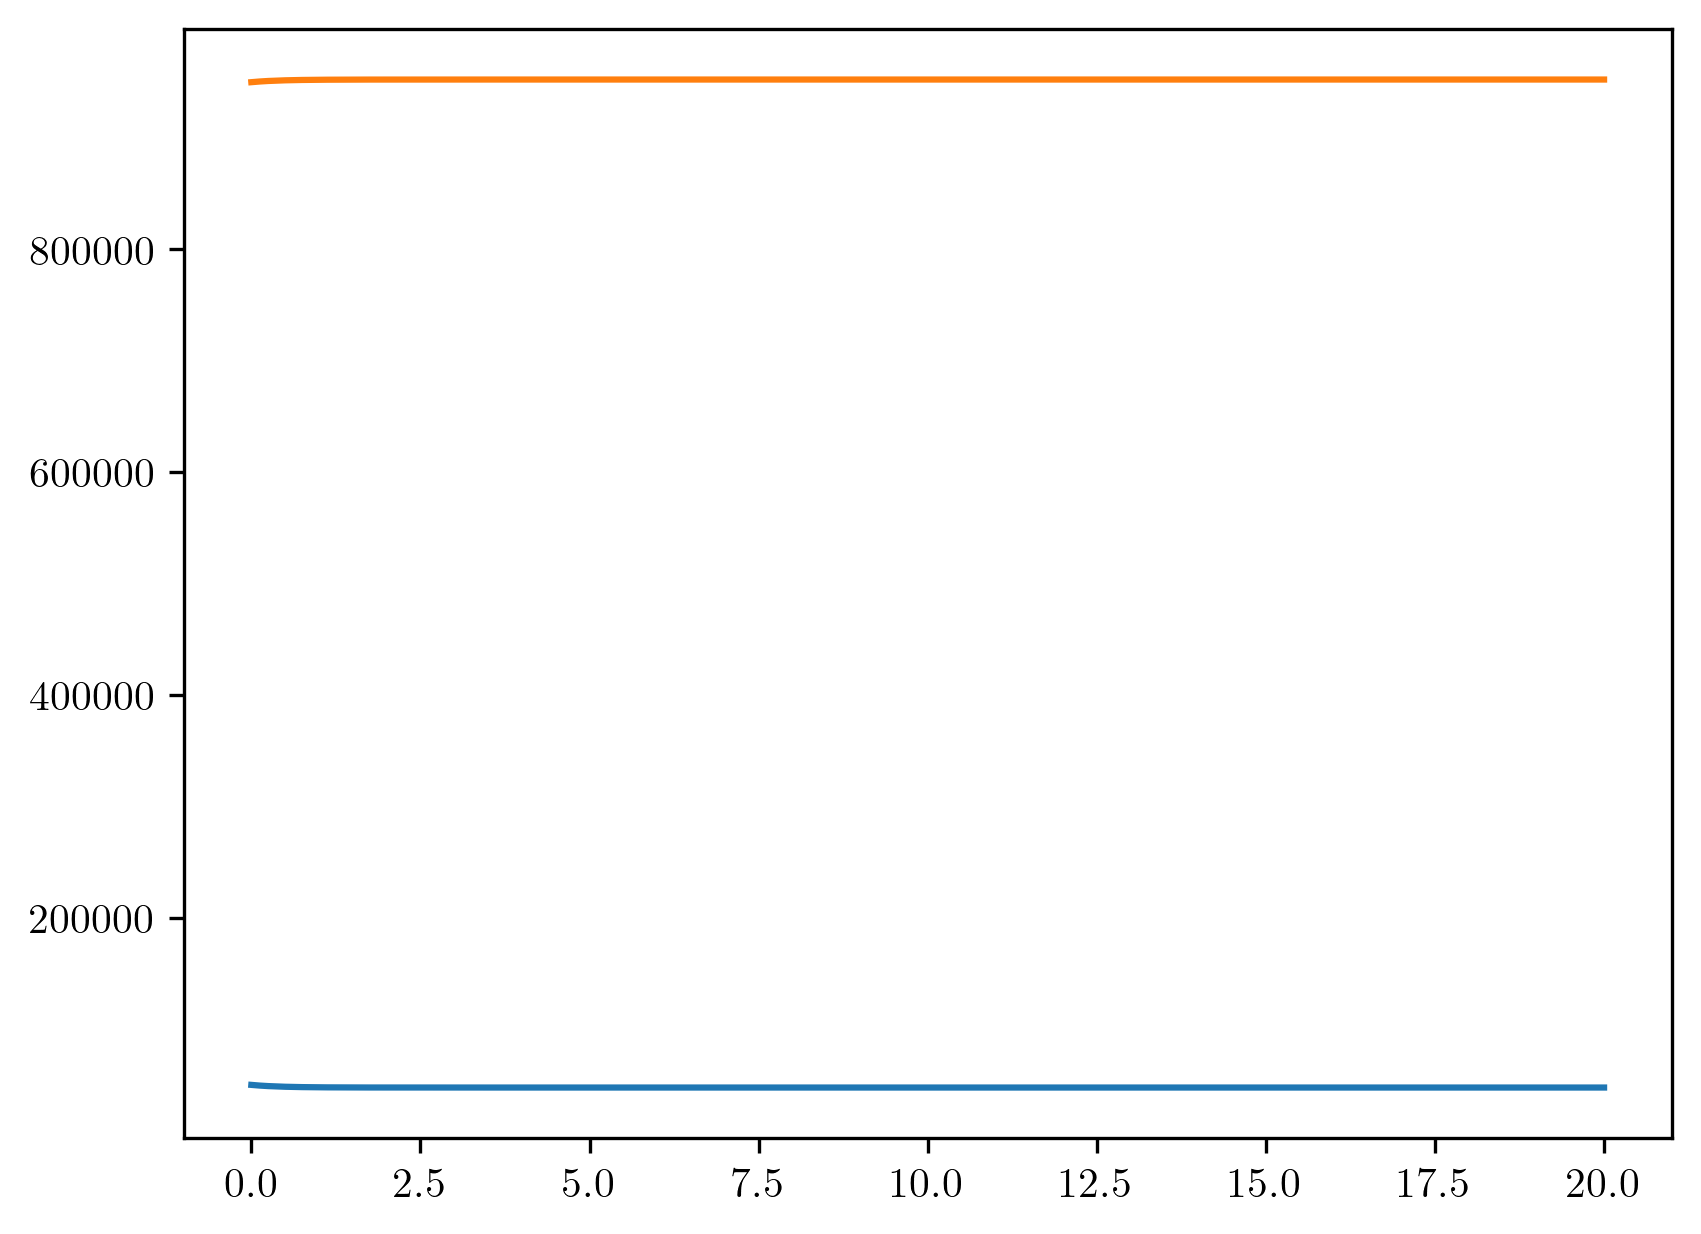

In [42]:
X = job_model.run()

plt.plot(X.Vacancies, label="Vacancies")
plt.plot(X.Employees, label="Employees")